In [ ]:
!pip install octis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 5.3 MB/s 
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
     |████████████████████████████████| 170 kB 41.3 MB/s 
     |████████████████████████████████| 22.3 MB 69.6 MB/s 
     |████████████████████████████████| 100 kB 9.2 MB/s 
     |████████████████████████████████| 16.5 MB 282 kB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 
     |████████████████████████████████| 4.7 MB 35.1 MB/s 
     |████████████████████████████████| 1.2 MB 71.7 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
     |████████████████████████████████| 6.6 MB 33.7 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233367 sha256=fd3ec77fdbd5daf9a992a2dab188c149bad5590ce966a35274cdf7458cf829e9
  Stored in directory: /root/.cache/pip/whe

In [ ]:
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

from octis.models.LDA import LDA
from octis.models.CTM import CTM
from octis.models.NeuralLDA import NeuralLDA
from octis.models.ProdLDA import ProdLDA
from octis.models.NMF import NMF
from octis.models.ETM import ETM

import os
import string
from octis.preprocessing.preprocessing import Preprocessing

import pandas as pd
import numpy as np
import inspect
import matplotlib.pyplot as plt
import time
import json
from numpy import transpose
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from PIL import Image
#from bertopic import BERTopic

In [ ]:
# Run this to mount the Notebook in your Google Drive account 
from google.colab import drive
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pd.read_csv('/content/drive/My Drive/nasa/OCTIS/zot2.csv')['title'].iloc[0]

'Search for Best Astronomical Observatory Sites in the MENA Region using Satellite Measurements'

In [ ]:
os.chdir(os.path.pardir)

# Initialize preprocessing
preprocessor = Preprocessing(vocabulary=None, max_features=None,
                             remove_punctuation=True, punctuation=string.punctuation,
                             lemmatize=True, stopword_list='english',
                             min_chars=1, min_words_docs=0)
# preprocess
dataset = preprocessor.preprocess_dataset(documents_path=r'/content/drive/My Drive/nasa/OCTIS/titles.csv')

# save the preprocessed dataset
dataset.save('zot')

created vocab
4856


All of the stuff above is the same as in previous notebooks.

We open our best output from our best model, CTM.
For a description of what each of these different components mean, check out this cool link: https://towardsdatascience.com/a-beginners-guide-to-octis-vol-2-optimizing-topic-models-1214e58be1e5

In [ ]:
ctm_output = {}

with open("/content/drive/My Drive/nasa/OCTIS/ctm_1", "r") as fp:
   ctm_output['topics'] = json.load(fp)

with open("/content/drive/My Drive/nasa/OCTIS/ctm_2", "r") as fp:
   ctm_output['topic-document-matrix'] = json.load(fp)

with open("/content/drive/My Drive/nasa/OCTIS/ctm_3", "r") as fp:
   ctm_output['test-topic-document-matrix'] = json.load(fp)

with open("/content/drive/My Drive/nasa/OCTIS/ctm_4", "r") as fp:
   ctm_output['topic-word-matrix'] = json.load(fp)

In [ ]:
topic_document_matrix = np.concatenate((ctm_output['topic-document-matrix'], ctm_output['test-topic-document-matrix']), axis=1)

GRAPH: the distribution of word weights in a topic

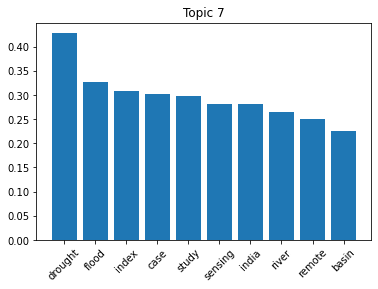

In [ ]:
def topic_word_dist(num, amt, output):
  indices = np.flip(np.argsort(output['topic-word-matrix'][num])[-amt:], 0).tolist()
  vals = []
  words = []
  for i in indices:
    vals.append(output['topic-word-matrix'][num][i])
    words.append(dataset.get_vocabulary()[i])
  
  plt.bar(words, vals)
  plt.xticks(rotation = 45)
  plt.title('Topic ' + str(num))


topicnum = 7
topic_word_dist(topicnum, 10, ctm_output)

In [ ]:
" ".join(ctm_output['topics'][0][0:4])

'summer diurnal monsoon cycle'

GRAPH: The weights of each topic for a document.

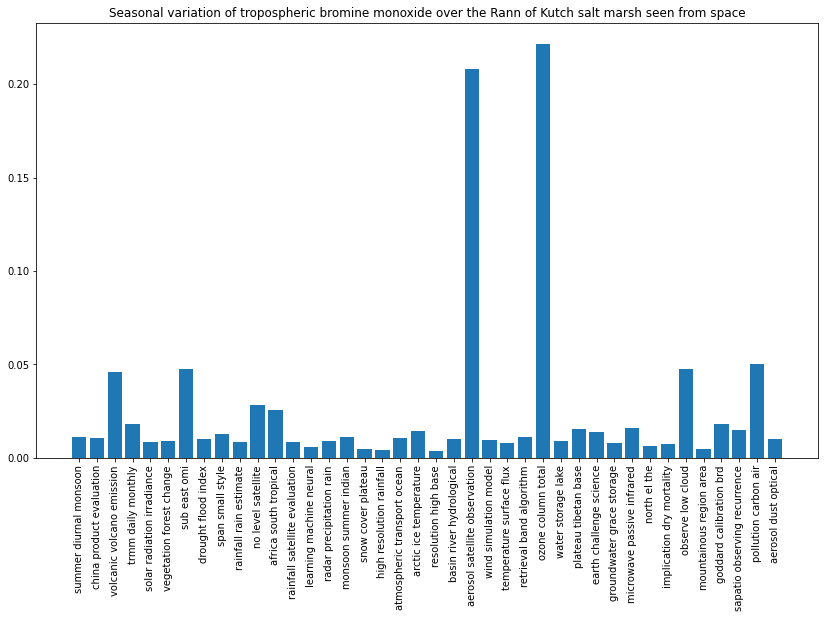

In [ ]:
def single_document_dist(num, output):
  matrix = transpose(topic_document_matrix)
  #indices = np.flip(np.argsort(matrix[num]), 0).tolist()
  vals = []
  topics = []
  for i in range(40):
    vals.append(matrix[num][i])
    topics.append(" ".join(output['topics'][i][0:3]))

  plt.figure( figsize=(14,8))
  plt.bar(topics, vals)
  plt.xticks(rotation = 90)
  plt.title(df['title'].iloc[num])

single_document_dist(250, ctm_output)
dataset.get_info()

GRAPH: All documents combined... we see that each topic has a relatively equal weighting overall, so it's not like some topics get a lot more documents. Is this a good or bad thing? It does contrast with models such as BERTopic.

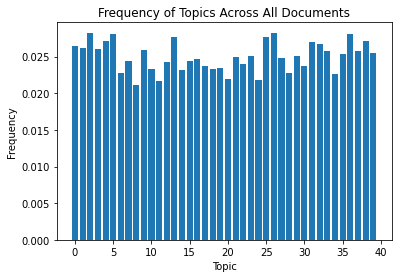

In [ ]:
def full_document_dist(threshold):
  matrix = transpose(topic_document_matrix)
  vals = [0] * matrix.shape[1]
  for doc in matrix:
    for topic in range(matrix.shape[1]):
      if doc[topic]:
        vals[topic] += doc[topic] / matrix.shape[0]

  plt.bar(range(40), vals)
  plt.xlabel('Topic')
  plt.ylabel('Frequency')
  plt.title('Frequency of Topics Across All Documents')


full_document_dist(1)

GRAPH: word clouds of a topic, with customization for shape and color among other things

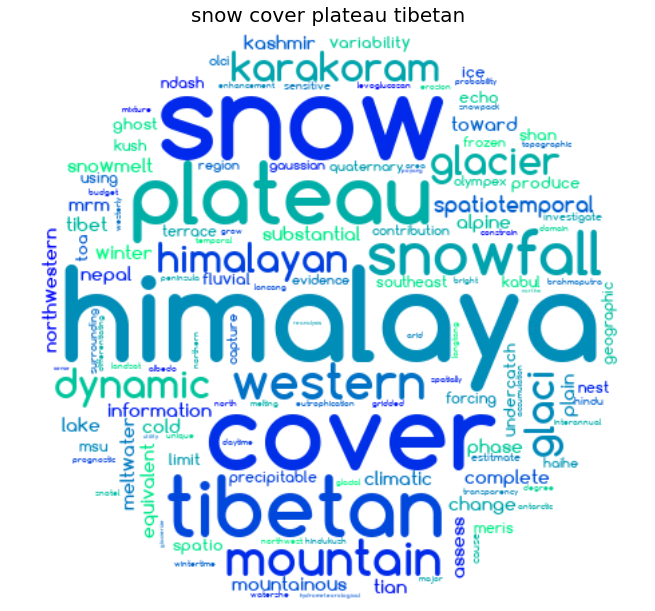

In [ ]:
def topic_word_cloud(num, output):
  font_path = "/content/drive/My Drive/nasa/OCTIS/Comfortaa-Bold.ttf"
  mask = np.array(Image.open("/content/drive/My Drive/nasa/OCTIS/circle.png"))
  indices = np.flip(np.argsort(output['topic-word-matrix'][num]), 0).tolist()
  word_list = []
  for i in indices:
    weight = output['topic-word-matrix'][num][i] * 20 // 1
    word = dataset.get_vocabulary()[i]
    for i in np.arange(weight):
      word_list.append(word)

  text = " ".join(word_list)
  
  word_cloud = WordCloud(collocations = False, width=1600, height=800, colormap='tab10', font_path=font_path,
                         max_words=300, background_color='white', prefer_horizontal=0.91, mask=mask).generate(text)
  # Display the generated Word Cloud
  plt.figure( figsize=(14,8))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.title(" ".join(output['topics'][num][0:4]), fontsize=20)
  plt.show()

topic_word_cloud(16, ctm_output)